In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

cuda


In [2]:
# Transforms

train_transform = T.Compose([
                       T.ToTensor(),
                       T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
                       T.RandomApply([T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)], p=0.4),
                       T.RandomHorizontalFlip(p=0.5),
                       T.RandomApply([T.RandomResizedCrop(size=32)], p=0.3)
])

validation_transform = T.Compose([
                      T.ToTensor(),
                      T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

test_transform = T.Compose([
                       T.ToTensor(),
                       T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

In [3]:
train_set = dset.CIFAR10('/root/sample_data', train=True, transform=train_transform, download=True)
validation_set = dset.CIFAR10('/root/sample_data', train=True, transform=validation_transform, download=True)
test_set = dset.CIFAR10('/root/sample_data', train=False, transform=test_transform, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /root/sample_data/cifar-10-python.tar.gz to /root/sample_data
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

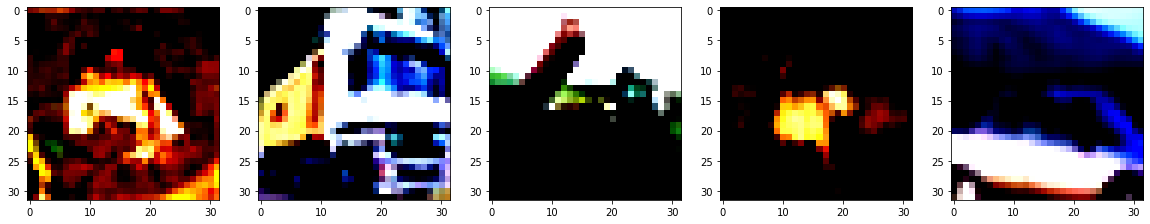

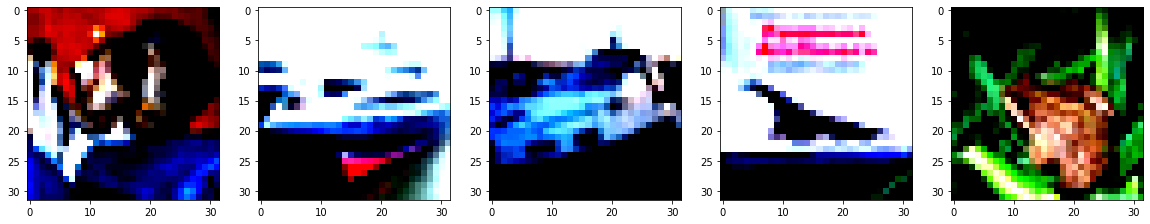

In [4]:
def print_some_images(dataset, start_num=0, num_img=5):

  """
  Print a few image from given dataset
  dataset - a dataset with tensors (images)
  start_num - an index of the image in the dataset from which the images are taken
  num_img - number of showing images (min = 1, max = 10)
  """

  import matplotlib.pyplot as plt

  if num_img < 1:
    num_img = 1
  elif num_img > 10:
    num_img = 10

  plt.figure(figsize=[20, 7])
  for i in range(num_img):
    plt.subplot(1, num_img, i + 1)
    img, _ = dataset.__getitem__(i + start_num)
    plt.imshow(img.permute(1, 2, 0))

print_some_images(train_set)
print_some_images(test_set)

In [5]:
NUM_TRAIN = 49000

train_loader = DataLoader(train_set, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0, NUM_TRAIN)))
validation_loader = DataLoader(validation_set, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
test_loader = DataLoader(test_set, batch_size=64)

In [6]:
def flatten(X):
  """
  Flatten an image to vector
  """
  N = X.shape[0] # Num in batch
  return X.view(N, -1)

class Flatten(nn.Module):
  def forward(self, X):
    return flatten(X)

In [32]:
model = None
optimizer = None

input_channels = 3
channel_1 = 128
channel_2 = 128
channel_3 = 64
channel_4 = 64
num_classes = 10

learning_rate = 1e-4
weight_decay = 1e-5

model = nn.Sequential(
    nn.Conv2d(in_channels=input_channels, out_channels=channel_1, kernel_size=5, stride=1, padding=2), # 32 x 32 x 128
    nn.BatchNorm2d(num_features=channel_1),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, 5, 1, 2), # 32 x 32 x 128
    nn.BatchNorm2d(num_features=channel_2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), # 16 x 16 x 128
    nn.Conv2d(channel_2, channel_3, kernel_size=3, stride=1, padding=1), # 16 x 16 x 64
    nn.BatchNorm2d(num_features=channel_3),
    nn.ReLU(),
    nn.Conv2d(channel_3, channel_4, kernel_size=3, stride=1, padding=1), # 16 x 16 x 64
    nn.BatchNorm2d(num_features=channel_4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), # 8 x 8 x 64
    Flatten(),
    nn.Linear(8 * 8 * 64, num_classes)
)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [21]:
def train_model(model, optimizer, trainLoader, validationLoader, num_epoch=1, device=torch.device('cpu'), printAndSaveEvery=100):
  
  import torch.nn.functional as F

  # best_model = None
  # best_acc = 0
  train_accuracies = []
  val_accuracies = []

  model = model.to(device=device)

  for e in range(num_epoch):
    for t, (x, y) in enumerate(trainLoader):

      model.train()
      x = x.to(device=device, dtype=torch.float32)
      y = y.to(device=device, dtype=torch.long)

      scores = model(x)
      loss = F.cross_entropy(scores, y)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      if t % printAndSaveEvery == 0:
        train_acc = check_accuracy(model, trainLoader, 'train', device)
        val_acc = check_accuracy(model, validationLoader, 'validation', device)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # if best_acc < val_acc:
        #   best_acc = val_acc
        #   best_model = 

    train_acc = check_accuracy(model, trainLoader, 'train', device)
    val_acc = check_accuracy(model, validationLoader, 'validation', device)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

In [34]:
def check_accuracy(model, dataLoader, typeOfCheck, device=torch.device('cpu')):
  """
  Checking accuracy on given dataSet in dataLoader
  typeOfCheck - train, validation or test
  """
  typeOfCheck = str.lower(typeOfCheck)

  model.eval()

  num_samples = 0
  num_correct = 0

  with torch.no_grad():
    for i, (x, y) in enumerate(dataLoader):
      x = x.to(device=device, dtype=torch.float32)
      y = y.to(device=device, dtype=torch.long)

      scores = model(x)
      _, preds = scores.max(1)

      num_samples += preds.shape[0]
      num_correct += (preds == y).sum()

      if typeOfCheck == 'train' and i == 100: # Чтобы проверяться не на всём огромном train сете (16 * 64 = 1024 как и у validation)
        break

    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f) in %s'% (num_correct, num_samples, 100 * acc, typeOfCheck))
    return acc

In [23]:
def check_overfit_on_small_data(model, dataSet, optimizer, device=torch.device('cpu')):
  
  import torch.nn.functional as F

  loader = DataLoader(dataSet, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0, 1000)))

  model.to(device=device)
  for t, (x, y) in enumerate(loader):
    model.train()
    x = x.to(device=device, dtype=torch.float32)
    y = y.to(device=device, dtype=torch.long)

    scores = model(x)
    loss = F.cross_entropy(scores, y)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    
    overfit_acc = check_accuracy(model, loader, 'overfit', device)
  
  overfit_acc = check_accuracy(model, loader, 'overfit', device)
  return(overfit_acc)

In [26]:
result = check_overfit_on_small_data(model, validation_set, optimizer, device)

Got 136 / 1000 correct (13.60)
Got 147 / 1000 correct (14.70)
Got 181 / 1000 correct (18.10)
Got 205 / 1000 correct (20.50)
Got 200 / 1000 correct (20.00)
Got 216 / 1000 correct (21.60)
Got 229 / 1000 correct (22.90)
Got 257 / 1000 correct (25.70)
Got 274 / 1000 correct (27.40)
Got 300 / 1000 correct (30.00)
Got 317 / 1000 correct (31.70)
Got 321 / 1000 correct (32.10)
Got 332 / 1000 correct (33.20)
Got 335 / 1000 correct (33.50)
Got 343 / 1000 correct (34.30)
Got 347 / 1000 correct (34.70)
Got 347 / 1000 correct (34.70)


In [35]:
model = None
optimizer = None

input_channels = 3
channel_1 = 128
channel_2 = 128
channel_3 = 64
channel_4 = 64
num_classes = 10

learning_rate = 1e-4
weight_decay = 1e-5

model = nn.Sequential(
    nn.Conv2d(in_channels=input_channels, out_channels=channel_1, kernel_size=5, stride=1, padding=2), # 32 x 32 x 128
    nn.BatchNorm2d(num_features=channel_1),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, 5, 1, 2), # 32 x 32 x 128
    nn.BatchNorm2d(num_features=channel_2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), # 16 x 16 x 128
    nn.Conv2d(channel_2, channel_3, kernel_size=3, stride=1, padding=1), # 16 x 16 x 64
    nn.BatchNorm2d(num_features=channel_3),
    nn.ReLU(),
    nn.Conv2d(channel_3, channel_4, kernel_size=3, stride=1, padding=1), # 16 x 16 x 64
    nn.BatchNorm2d(num_features=channel_4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), # 8 x 8 x 64
    Flatten(),
    nn.Linear(8 * 8 * 64, num_classes)
)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_model(model, optimizer, train_loader, validation_loader, 10, device, 100)

Got 719 / 6464 correct (11.12) in train
Got 116 / 1000 correct (11.60) in validation
Got 2133 / 6464 correct (33.00) in train
Got 429 / 1000 correct (42.90) in validation
Got 2442 / 6464 correct (37.78) in train
Got 490 / 1000 correct (49.00) in validation
Got 2673 / 6464 correct (41.35) in train
Got 525 / 1000 correct (52.50) in validation
Got 2879 / 6464 correct (44.54) in train
Got 537 / 1000 correct (53.70) in validation
Got 2843 / 6464 correct (43.98) in train
Got 542 / 1000 correct (54.20) in validation
Got 3102 / 6464 correct (47.99) in train
Got 572 / 1000 correct (57.20) in validation
Got 2976 / 6464 correct (46.04) in train
Got 575 / 1000 correct (57.50) in validation
Got 3159 / 6464 correct (48.87) in train
Got 586 / 1000 correct (58.60) in validation
Got 3153 / 6464 correct (48.78) in train
Got 581 / 1000 correct (58.10) in validation
Got 3328 / 6464 correct (51.49) in train
Got 620 / 1000 correct (62.00) in validation
Got 3201 / 6464 correct (49.52) in train
Got 609 / 1000

NameError: ignored

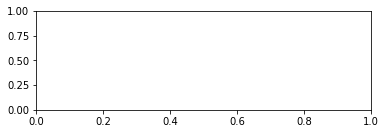

In [36]:
plt.subplot(2, 1, 1)
plt.plot(train_accuracies)
plt.subplot(2, 1, 2)
plt.plot(validation_accuracies)

In [37]:
check_accuracy(model, test_loader, 'test', device)

Got 7626 / 10000 correct (76.26) in test


0.7626